# Imports

## tf

In [4]:
import scipy
print(scipy.__version__)

1.10.1


In [ ]:
from glob import glob
import os
from pathlib import Path
import random as rn
import sys

import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import yaml

from deepface import basemodels

sys.path.append("../")

from age_module.src.models import img_utils
from age_module.src.models import inference
from age_module.src.models import tf_mem

# Consts

In [ ]:
# Train
GPU_GB_LIMIT = 6
BATCH_SIZE = 72

experiment_name = "age_prediction"

# Existent folders
img_folder = r"../utkface_aligned_cropped/UTKFace/"
yaml_path = r"../configs/age_esteem.yaml"
# Weight save file
cpt_path = r"../age_module/weights/age_checkpoint_best.h5"

SEED = 42
CLASS_MODE = "raw"

### Limit train GPU

In [ ]:
# prevent overflow
tf_mem.limit_gpu_gb(gpu_gb_limit)

# Data

In [ ]:
filenames = sorted(glob(f"{Path(img_folder).resolve()}/*.jpg"))
print(len(filenames))

In [ ]:
df_path = sorted(glob(f"{img_folder}/*.csv"))[0]

In [ ]:
df = pd.read_csv(
    df_path, sep=";", names=["filename", "side", "person_id", "indicator", "age"]
)
df.sample(5)

# Age model

In [ ]:
mlflow.set_experiment("age_prediction_experiment")

In [ ]:
lr = 0.001

In [ ]:
target_col = "age"

In [ ]:
def objective(trial):
    with mlflow.start_run():
        EPOCHS = 200
        
        base_model_name = trial.suggest_categorical('base_model_name', ['Facenet', 'Facenet512', 'ArcFace', 'VGGFace'])
        base_model_class = getattr(basemodels, base_model_name)
        full_model = base_model_class.loadModel()
        embedder = tf.keras.Model([full_model.input], full_model.get_layer(index=-1).output)
        embedder.trainable = False

        input_age = full_model.layers[0].input_shape[0][1:]
        input_layer = Input(shape=input_age)

        base_model_main = embedder(input_layer)
        apply_gap = trial.suggest_categorical('apply_gap', [True, False])
        if apply_gap:
            base_model_main = GlobalAveragePooling2D()(base_model_main)

        pre_final_units = trial.suggest_int('pre_final_units', 64, 256, step=64)
        pre_final_activation = trial.suggest_categorical('pre_final_activation', ['relu', 'tanh'])
        pre_final = Dense(pre_final_units, activation=pre_final_activation)(base_model_main)
        age_output = Dense(1, activation="relu")(pre_final)

        model = tf.keras.Model(inputs=input_layer, outputs=age_output)
        #model.summary()

        # Compile
        optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
        optimizer = tf.keras.optimizers.get(optimizer_name)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        # Log the parameters
        mlflow.log_params({
            'base_model_name': base_model_name,
            'apply_gap': apply_gap,
            'pre_final_units': pre_final_units,
            'pre_final_activation': pre_final_activation,
            'optimizer': optimizer_name
        })

        # Train
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=val_generator,
            callbacks=callbacks,
            steps_per_epoch=50,
            validation_steps=len(df_val) // BATCH_SIZE,
        )

        # Evaluate 
        val_loss, val_mae = model.evaluate(val_generator)
        
        mlflow.log_metrics({'val_loss': val_loss, 'val_mae': val_mae})
        
        mlflow.keras.log_model(model, "model")

        return val_mae


# Dataset

In [ ]:
target_size = input_age[:2]  # (224, 224)

# Reproducibility 1/2

In [ ]:
def set_seed(seed=SEED):
    np.random.seed(seed)
    rn.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    K.set_session(sess)


set_seed(SEED)

# Train test split

In [ ]:
df_train, df_temp, _, _ = train_test_split(
    df, df[target_col], test_size=0.2, random_state=SEED
)

df_val, df_test, _, _ = train_test_split(
    df_temp, df_temp[target_col], test_size=0.5, random_state=SEED
)

print("Train count:", len(df_train))
print("Validation count:", len(df_val))

## Store split to file reproducibility 2/2

In [ ]:
train_names = df_train["filename"].tolist()
val_names = df_val["filename"].tolist()
test_names = df_test["filename"].tolist()

split_info = {"train": train_names, "val": val_names, "test": test_names}

yaml_path = "./evaluation_data/split_info.yaml"

with open(yaml_path, "w") as yaml_file:
    yaml.dump(split_info, yaml_file)

# Check preproc

In [ ]:
preproc_deepface = img_utils.PreprocDeepface(base_model_name, target_size)

In [ ]:
img_name = "81_1_0_20170120134927295.jpg.chip.jpg"
img_path = f"{img_folder}/{img_name}"
nn_input_example = preproc_deepface.preproc_by_path(img_path, target_size)
print(nn_input_example)

In [ ]:
plt.imshow(nn_input_example[0, :])

In [ ]:
print(nn_input_example.max(), nn_input_example.min())

In [ ]:
nn_input_example.shape

# Data generators

In [ ]:
target_size

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=preproc_deepface.preproc_img)

In [ ]:
train_generator = image_gen.flow_from_dataframe(
    dataframe=df_train,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [ ]:
val_generator = image_gen.flow_from_dataframe(
    dataframe=df_val,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Train execute

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Save the best model details
best_trial = study.best_trial
age_dict = {
    "age_best_model_path": cpt_path,
    "age_preproc_family": best_trial.params['base_model_name'],
    "target_size": list(target_size),
}

# Score on test

In [38]:
#model = load_model("../weights/Facenet_121_age_checkpoint_best.h5")
model_path = mlflow.get_artifact_uri('model')
model = study.load_model(model_path)

In [117]:
test_generator = image_gen.flow_from_dataframe(
    dataframe=df_test,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 2370 validated image filenames.


In [118]:
results = model.evaluate(test_generator, steps=len(df_test) // BATCH_SIZE)

32/32 [==============================] - 3s 96ms/step - loss: 61.5504 - mean_absolute_error: 5.7145


# Example inference

In [134]:
im_orig = load_img(img_path, target_size=target_size)

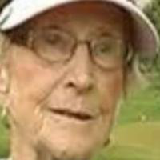

In [135]:
im_orig

In [145]:
age_pred = inference.esteem_age(im_orig, model, preproc_deepface.preproc_img)

age_pred

array([[84.39782]], dtype=float32)

In [147]:
age_pred[0][0]

84.39782